<div style="text-align: center;">
    <h1>
        <a href="https://www.kaggle.com/competitions/word2vec-nlp-tutorial" target="_blank">Bag of Words Meets Bags of Popcorn</a>
    </h1>
    <h3>Mohammad Nourbakhsh Marvast</h3>
</div>


# Bag of Words Meets Bags of Popcorn Project

In this project, I implement a basic NLP pipeline on the IMDB movie-review dataset from the Kaggle “Bag of Words Meets Bags of Popcorn” competition, which contains 50,000 labeled reviews evenly split between positive and negative sentiments Kaggle.

First, I preprocess the text by removing HTML tags, non-alphabetic characters, and converting to lowercase, then tokenize each review into words using NLTK’s word_tokenize function to create a clean corpus for feature extraction
CodeSignal.

Next, I transform the tokenized text into numerical features using the Bag-of-Words model via scikit-learn’s CountVectorizer, which counts the occurrences of each token across the corpus, and optionally apply TfidfVectorizer to weight terms by their inverse document frequency, improving the signal-to-noise ratio in the feature space
Analytics Vidhya.

Finally, I train a simple classifier—such as Multinomial Naïve Bayes or Logistic Regression—on the extracted feature matrix and evaluate the model’s performance using accuracy and the Area Under the ROC Curve (AUC) on the held-out test set, establishing a strong baseline before experimenting with more advanced models.

# Imports

In [1]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;

from sklearn.model_selection import train_test_split;
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score;

# Loading Data

In [4]:
labeled_train_df= pd.read_csv("labeledTrainData.tsv/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

In [5]:
labeled_train_df.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [6]:
labeled_train_df['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

# Data Cleaning

## Removing HTML Tags

In [7]:
from bs4 import BeautifulSoup

In [8]:
def remove_html(raw_review):

  review = BeautifulSoup(raw_review).get_text()

  return review

In [9]:
remove_html(labeled_train_df['review'][0])

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 2

## Dealing with Punctuation, Numbers, Stopwords, and Extraction of the Root of Words

In [10]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def meaning_extraction(raw_review, stop_words= set(stopwords.words('english'))):

  # 1. Strip HTML and lowercase
  #print('Removing HTML Tags')
  #print('====================')
  review = remove_html(raw_review).lower()

  # 2. Collapse any char repeated ≥3 times to exactly 2
    #    e.g. "sooooo" → "soo", "haaaaaap" → "haap"
  review = re.sub(r'(.)\1{2,}', r'\1\1', review)

  # 3. Remove everything except a–z, replace with spaces
  #print('Removing Meaningless Characters')
  #print('====================')
  clean_review = re.sub(pattern= '[^a-z]',
                        repl= ' ',
                        string = review)
  words = clean_review.split(' ')

  # 4. Tokenize on whitespace and Stem and filter stopwords
  #print('MeaningFul Words Extraction')
  #print('====================')
  ps = PorterStemmer()
  meaningful_words = [ps.stem(w.strip()) for w in words if (w.strip()) and (not w in stop_words)]

  return ' '.join(meaningful_words)




In [13]:
temp_df= labeled_train_df.copy()

In [14]:
temp_df.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [15]:
stop_words= set(stopwords.words('english'))
temp_df['review']= temp_df['review'].apply(meaning_extraction, stop_words)

<ipython-input-15-38ff492eca84>:2: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  temp_df['review']= temp_df['review'].apply(meaning_extraction, stop_words)


## Vectorize Reviews Bag of Words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
# This pattern matches words with up to two consecutive repeated characters
vectorizer = CountVectorizer(max_features= 5000,
                             lowercase= False)
list_reviews = list(temp_df['review'])
vectorized_reviews = vectorizer.fit_transform(list_reviews)

In [18]:
vectorized_reviews

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2086644 stored elements and shape (25000, 5000)>

In [19]:
vectorizer.get_feature_names_out()

array(['abandon', 'abc', 'abil', ..., 'zombi', 'zone', 'zoom'],
      dtype=object)

# Model Training

In [20]:
X= vectorized_reviews.toarray()
y= labeled_train_df['sentiment']

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [25]:
X_val = scaler.transform(X_val)

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
model= LogisticRegression(max_iter= 200)
model.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [28]:
y_pred = model.predict(X_val)

Model Evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3146
           1       0.87      0.88      0.88      3104

    accuracy                           0.88      6250
   macro avg       0.88      0.88      0.88      6250
weighted avg       0.88      0.88      0.88      6250


Confusion Matrix


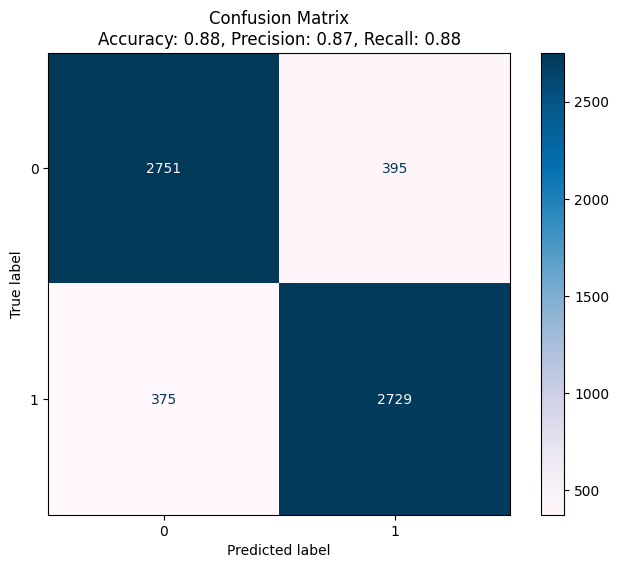

In [29]:
print('====================')
print('Model Evaluation')
print('====================')
print()

print('====================')
print('Classification Report')
print('====================')
print(classification_report(y_val, y_pred))
print()

print('====================')
print('Confusion Matrix')
print('====================')
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary')
recall = recall_score(y_val, y_pred, average='binary')

class_names = [0,1]
cm = confusion_matrix(y_val, y_pred, labels=class_names)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='PuBu', values_format='d')
ax.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.show()

## Naive Bayes

In [30]:
from sklearn.naive_bayes import BernoulliNB

In [31]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB()

In [32]:
y_pred = model.predict(X_val)

Model Evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3146
           1       0.86      0.82      0.84      3104

    accuracy                           0.84      6250
   macro avg       0.84      0.84      0.84      6250
weighted avg       0.84      0.84      0.84      6250


Confusion Matrix


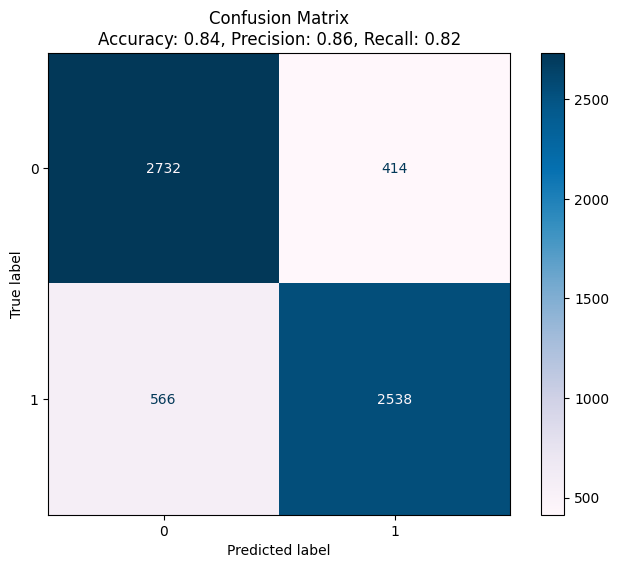

In [33]:
print('====================')
print('Model Evaluation')
print('====================')
print()

print('====================')
print('Classification Report')
print('====================')
print(classification_report(y_val, y_pred))
print()

print('====================')
print('Confusion Matrix')
print('====================')
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary')
recall = recall_score(y_val, y_pred, average='binary')

class_names = [0,1]
cm = confusion_matrix(y_val, y_pred, labels=class_names)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='PuBu', values_format='d')
ax.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.show()

## Support Vector Machine

In [34]:
from sklearn.svm import LinearSVC

In [35]:
model = LinearSVC()
model.fit(X_train, y_train)

LinearSVC()

In [36]:
y_pred = model.predict(X_val)

Model Evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3146
           1       0.86      0.85      0.85      3104

    accuracy                           0.86      6250
   macro avg       0.86      0.86      0.86      6250
weighted avg       0.86      0.86      0.86      6250


Confusion Matrix


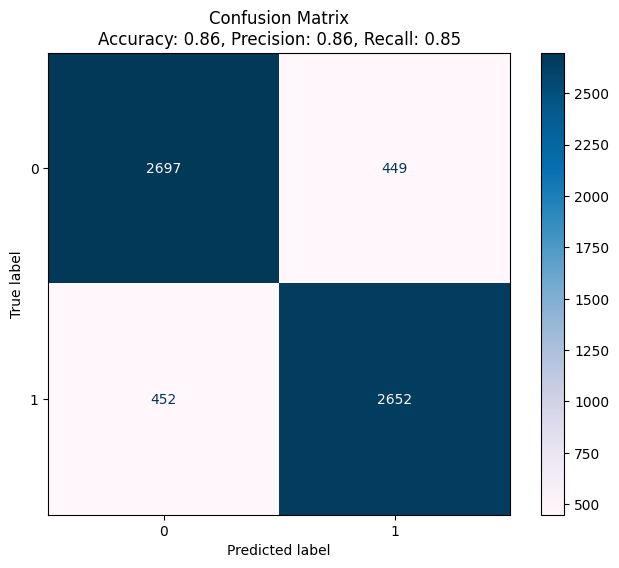

In [37]:
print('====================')
print('Model Evaluation')
print('====================')
print()

print('====================')
print('Classification Report')
print('====================')
print(classification_report(y_val, y_pred))
print()

print('====================')
print('Confusion Matrix')
print('====================')
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary')
recall = recall_score(y_val, y_pred, average='binary')

class_names = [0,1]
cm = confusion_matrix(y_val, y_pred, labels=class_names)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='PuBu', values_format='d')
ax.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.show()